In [124]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import librosa
import os
import time
from tempfile import TemporaryDirectory
from torchvision import datasets, models, transforms
from sklearn.preprocessing import minmax_scale
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [128]:
def extract_features(filepath):
    y, sr = librosa.load(filepath)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    cens = librosa.feature.chroma_cens(y=y, sr=sr)
    n_fft = 2048
    hop_length = 512
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    combined_features = np.concatenate([mfccs, centroid, cens, mel_spectrogram], axis=0)
    normalized_features = minmax_scale(combined_features, axis=1) 
    return normalized_features

In [3]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.inputs = []
        self.labels = []
        self.transform=transform
        for i in range(4):
            print('loading class '+str(i))
            for filename in os.listdir(data + str(i)):
                audio_file = str(data + str(i) + "/" + filename)
                spectrogram = extract_features(audio_file)
                #print(audio_file+' '+str(spectrogram.shape))
                if spectrogram is not None:  
                    self.inputs.append(spectrogram)
                    self.labels.append(i)


        self.inputs = np.stack(self.inputs)
        self.labels = np.array(self.labels)

        self.inputs = torch.tensor(self.inputs, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = self.inputs[idx]
        target = self.labels[idx]

        if self.transform:
            item = self.transform(item)

        return item, target
    
transform=transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])
db=MyDataset('./data/1200songs2/',transform=transform)
db_test=MyDataset('./data/1200songs2_test/',transform=transform)

./data/1200songs2/0/blue Kamal..mp3 (161, 1292)
./data/1200songs2/0/Breathe Me Sia.mp3 (161, 1292)
./data/1200songs2/0/Bruises Lewis Capaldi.mp3 (161, 1292)
./data/1200songs2/0/Californication Red Hot Chili Peppers.mp3 (161, 1292)
./data/1200songs2/0/caroline sombr.mp3 (161, 1292)
./data/1200songs2/0/ceilings Lizzy McAlpine.mp3 (161, 1292)
./data/1200songs2/0/cellophane FKA twigs.mp3 (161, 1292)
./data/1200songs2/0/Change Alex G.mp3 (161, 1292)
./data/1200songs2/0/Chariot Beach House.mp3 (161, 1292)
./data/1200songs2/0/Cherry Wine - Live Hozier.mp3 (161, 1292)
./data/1200songs2/0/Cold Arms Mumford & Sons.mp3 (161, 1292)
./data/1200songs2/0/Cold Nights Camo Columbo.mp3 (161, 1292)
./data/1200songs2/0/comethru Jeremy Zucker.mp3 (161, 1292)
./data/1200songs2/0/Coming Down Dum Dum Girls.mp3 (161, 1292)
./data/1200songs2/0/complex (demo) Katie Gregson-MacLeod.mp3 (161, 1292)
./data/1200songs2/0/Consequences Camila Cabello.mp3 (161, 1292)
./data/1200songs2/0/Conversation Lucy Rose.mp3 (161, 

In [160]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.inputs = []
        self.labels = []
        self.transform=transform
        for i in range(4):
            print('loading class '+str(i))
            for filename in os.listdir(data + str(i)):
                audio_file = str(data + str(i) + "/" + filename)
                spectrogram = extract_features(audio_file)
                spectrogram=spectrogram[:,:1290]
                spectrogram=torch.tensor(spectrogram)
                
                if spectrogram is not None:  
                    onethird=spectrogram[:,:1290//3]
                    twothirds=spectrogram[:,1290//3:1290//3*2]
                    threethirds=spectrogram[:,1290//3*2:]
                    
                    combined=torch.stack([onethird,twothirds,threethirds])
                    combined=combined.unsqueeze(1)

                    self.inputs.append(combined)
                    self.labels.append(i)



        self.inputs = np.stack(self.inputs)
        self.labels = np.array(self.labels)

        self.inputs = torch.tensor(self.inputs, dtype=torch.float32)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = self.inputs[idx]
        target = self.labels[idx]

        if self.transform:
            item = self.transform(item)

        return item, target
    
transform=transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])
db=MyDataset('./data/1200songs2/',transform=transform)
#db_test=MyDataset('./data/1200songs2_test/',transform=transform)

loading class 0
loading class 1
loading class 2
loading class 3


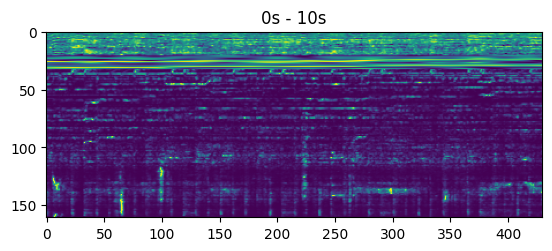

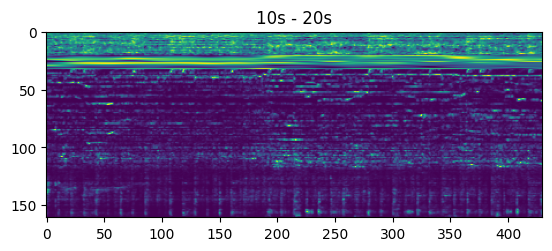

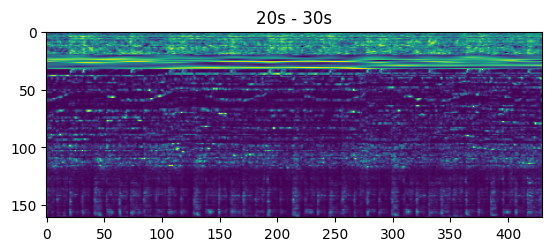

In [261]:
test_loader=torch.utils.data.DataLoader(db_test,batch_size=4,shuffle=False)
train_loader=torch.utils.data.DataLoader(db,batch_size=2,shuffle=True)
for i, (data, target) in enumerate(test_loader):
    song=data[0]
    for i in range(3):
        plt.title(f'{10*i}s - {10*(i+1)}s')
        plt.imshow(song[i][0].detach().numpy())
        plt.show()

    break

In [256]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, seq_length, num_layers, num_classes):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length


        self.conv1=nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(10,10),stride=(1,1))
        self.pooling1=nn.MaxPool2d(kernel_size=(4,4),stride=(4,4))
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1))
        self.pooling2=nn.MaxPool2d(kernel_size=(4,4),stride=(4,4))
        self.conv3=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1))
        self.pooling3=nn.MaxPool2d(kernel_size=(3,3),stride=(3,3))
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm2d(64)
        self.batchnorm2=nn.BatchNorm2d(128)
        self.batchnorm3=nn.BatchNorm2d(128)
        self.dropout=nn.Dropout2d(0.05)
        self.fc1=nn.Linear(128*2*7,256)
        self.fc2=nn.Linear(hidden_size, num_classes)


        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        sequences=[]
        x=x.permute(1,0,2,3,4)
        for sequence in x:
            sequence=self.conv1(sequence)
            sequence=self.batchnorm1(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling1(sequence)

            sequence=self.conv2(sequence)
            sequence=self.batchnorm2(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling2(sequence)

            sequence=self.conv3(sequence)
            sequence=self.batchnorm3(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling3(sequence)

            sequence=torch.flatten(sequence,1)
            sequence=self.fc1(sequence)
            sequences.append(sequence)

        
        x=torch.stack(sequences)
        x=x.permute(1,0,2)

        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out=out[:,-1,:]
        out=self.fc2(out)
        out=F.softmax(out,dim=1)
        return out

class ResNetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length, num_layers, num_classes):
        super(ResNetLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        resnet = models.resnet18(pretrained=True)
        #change to 1 channel input
        resnet.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.resnet.eval()

        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, bidirectional=False, batch_first=True)
        self.fc1=nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        sequences=[]
        x=x.permute(1,0,2,3,4)
        for sequence in x:
            sequence=self.resnet(sequence)
            sequence=torch.flatten(sequence,1)
            sequences.append(sequence)

        
        x=torch.stack(sequences)
        x=x.permute(1,0,2)
        #return x
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out=out[:,-1,:]
        out=self.fc1(out)
        out=F.softmax(out,dim=1)
        return out

class LSTMModelBi(nn.Module):
    
    def __init__(self, input_size, hidden_size, seq_length, num_layers, num_classes):
        super(LSTMModelBi, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length


        self.conv1=nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(10,10),stride=(1,1))
        self.pooling1=nn.MaxPool2d(kernel_size=(4,4),stride=(4,4))
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1))
        self.pooling2=nn.MaxPool2d(kernel_size=(4,4),stride=(4,4))
        self.conv3=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1))
        self.pooling3=nn.MaxPool2d(kernel_size=(3,3),stride=(3,3))
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm2d(64)
        self.batchnorm2=nn.BatchNorm2d(128)
        self.batchnorm3=nn.BatchNorm2d(128)
        self.dropout=nn.Dropout2d(0.05)
        self.fc1=nn.Linear(128*2*7,256)
        self.fc2=nn.Linear(hidden_size,num_classes)

        self.lstm=nn.LSTM(input_size, hidden_size // 2, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        sequences=[]
        x=x.permute(1,0,2,3,4)
        for sequence in x:
            sequence=self.conv1(sequence)
            sequence=self.batchnorm1(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling1(sequence)

            sequence=self.conv2(sequence)
            sequence=self.batchnorm2(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling2(sequence)

            sequence=self.conv3(sequence)
            sequence=self.batchnorm3(sequence)
            sequence=self.dropout(sequence)
            sequence=self.relu(sequence)
            sequence=self.pooling3(sequence)

            sequence=torch.flatten(sequence,1)
            sequence=self.fc1(sequence)
            sequences.append(sequence)

        
        x=torch.stack(sequences)
        x=x.permute(1,0,2)

        h0=torch.zeros(self.num_layers * 2,x.size(0),self.hidden_size // 2).to(device)
        c0=torch.zeros(self.num_layers * 2,x.size(0),self.hidden_size // 2).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.cat((out[:, -1, :self.hidden_size // 2], out[:, 0, self.hidden_size // 2:]), dim=1)
        out=self.fc2(out)
        out=F.softmax(out,dim=1)
        return out
    
class ResNetBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length, num_layers, num_classes):
        super(ResNetBiLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        resnet = models.resnet18(pretrained=True)
        resnet.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.resnet.eval()

        # Bidirectional LSTM
        self.lstm=nn.LSTM(input_size, hidden_size // 2, num_layers, bidirectional=True, batch_first=True)
        # Double the size of fc1 input
        self.fc1=nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        sequences=[]
        x=x.permute(1,0,2,3,4)
        for sequence in x:
            sequence=self.resnet(sequence)
            sequence=torch.flatten(sequence,1)
            sequences.append(sequence)

        x=torch.stack(sequences)
        x=x.permute(1,0,2)
        
        h0=torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size // 2).to(device)
        c0=torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size // 2).to(device)
        out, _ = self.lstm(x, (h0, c0))


        out = torch.cat((out[:, -1, :self.hidden_size // 2], out[:, 0, self.hidden_size // 2:]), dim=1)
        out = self.fc1(out)
        out = F.softmax(out, dim=1)
        return out


In [212]:
def train(model,criterion,optimizer,scheduler,num_epochs,dataloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', device)
    model.to(device)
    model.train()
    losses=[]

    since=time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path=os.path.join(tempdir,'best_model.pth')

        torch.save(model.state_dict(),best_model_params_path)
        best_acc=0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-'*10)
            running_loss = 0.0
            running_corrects = 0
            for inputs,labels in dataloader:
                inputs=inputs.to(device)
                labels=labels.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs=model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss=criterion(outputs,labels)

                    loss.backward()
                    optimizer.step()
                
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            epoch_loss=running_loss/len(dataloader.dataset)
            epoch_acc=running_corrects.double()/len(dataloader.dataset)
            scheduler.step()

            print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            losses.append(epoch_loss)
            if epoch_acc>best_acc:
                best_acc=epoch_acc
                torch.save(model.state_dict(),best_model_params_path)

        time_elapsed=time.time()-since
        print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
        print(f'Best val acc: {best_acc:.4f}')
        model.load_state_dict(torch.load(best_model_params_path))
        plt.plot(losses)

Using device: cuda:0
Epoch 0/49
----------
Loss: 1.2879 Acc: 0.4367
Epoch 1/49
----------
Loss: 1.1757 Acc: 0.5816
Epoch 2/49
----------
Loss: 1.1093 Acc: 0.6401
Epoch 3/49
----------
Loss: 1.0519 Acc: 0.7044
Epoch 4/49
----------
Loss: 1.0209 Acc: 0.7303
Epoch 5/49
----------
Loss: 0.9803 Acc: 0.7764
Epoch 6/49
----------
Loss: 0.9647 Acc: 0.7965
Epoch 7/49
----------
Loss: 0.9568 Acc: 0.7965
Epoch 8/49
----------
Loss: 0.9530 Acc: 0.7975
Epoch 9/49
----------
Loss: 0.9493 Acc: 0.7994
Epoch 10/49
----------
Loss: 0.9464 Acc: 0.8081
Epoch 11/49
----------
Loss: 0.9457 Acc: 0.8013
Epoch 12/49
----------
Loss: 0.9420 Acc: 0.8138
Epoch 13/49
----------
Loss: 0.9378 Acc: 0.8177
Epoch 14/49
----------
Loss: 0.9383 Acc: 0.8196
Epoch 15/49
----------
Loss: 0.9416 Acc: 0.8157
Epoch 16/49
----------
Loss: 0.9383 Acc: 0.8129
Epoch 17/49
----------
Loss: 0.9375 Acc: 0.8100
Epoch 18/49
----------
Loss: 0.9391 Acc: 0.8148
Epoch 19/49
----------
Loss: 0.9390 Acc: 0.8119
Epoch 20/49
----------
Loss: 

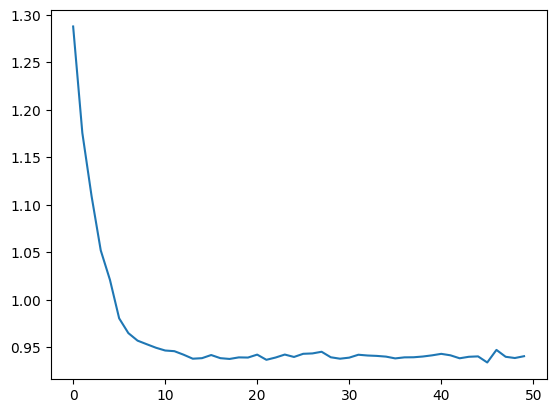

In [232]:
model=LSTMModelBi(input_size=256,hidden_size=128,seq_length=3,num_layers=2,num_classes=4)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
#optimizer=optim.SGD(modelRes.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train(model,criterion,optimizer,exp_lr_scheduler,50,train_loader)

torch.save(model.state_dict(),'modelLSTM50.pth')


In [262]:
#model=LSTMModel(input_size=256,hidden_size=128,seq_length=3,num_layers=2,num_classes=4)
modelRes=LSTMModelBi(input_size=256,hidden_size=128,seq_length=3,num_layers=2,num_classes=4)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(modelRes.parameters(),lr=0.0001)
#optimizer=optim.SGD(modelRes.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train(modelRes,criterion,optimizer,exp_lr_scheduler,10,train_loader)

torch.save(model.state_dict(),'modelRES50V2.pth')

Using device: cuda:0
Epoch 0/9
----------


KeyboardInterrupt: 

In [255]:

modelRes.eval()
with torch.no_grad():
    corrects=0
    samples=0
    for inputs,labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=modelRes(inputs)
        _, preds = torch.max(outputs, 1)
        corrects+=torch.sum(preds==labels.data)
        samples+=len(labels)

    print(f'Accuracy LSTM: {corrects.double()/samples:.4f}')

Accuracy LSTM: 0.7917


In [263]:
#torch.save(model.state_dict(),'lstmresnet_bi86acc3seq.pth')
#load model 
model = ResNetBiLSTM(input_size=512, hidden_size=128, seq_length=3, num_layers=2, num_classes=4)
model.load_state_dict(torch.load('lstmresnet_bi86acc3seq.pth'))

model.to(device)
model.eval()
with torch.no_grad():
    corrects=0
    samples=0
    for inputs,labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects+=torch.sum(preds==labels.data)
        samples+=len(labels)

    print(f'Accuracy LSTM: {corrects.double()/samples:.4f}')


c:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy LSTM: 0.8583


In [199]:
#batch of 4 1x161x1292 random matrix
input=torch.randn(4,3,1,161,430)
input=input.to(device)

print(input.shape)
#model=LSTMModel(input_size=256,hidden_size=128,seq_length=3,num_layers=2,num_classes=4).to(device)
modelRES=ResNetLSTM(input_size=512,hidden_size=128,seq_length=3,num_layers=2,num_classes=4).to(device)
output=modelRES(input)
print(output)



torch.Size([4, 3, 1, 161, 430])
tensor([[0.2508, 0.2624, 0.2399, 0.2469],
        [0.2505, 0.2618, 0.2402, 0.2475],
        [0.2506, 0.2630, 0.2392, 0.2471],
        [0.2508, 0.2627, 0.2398, 0.2467]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
